## Data Processing & Exploratory

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from catboost import Pool, CatBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
import yfinance as yf
import optuna
import warnings
warnings.filterwarnings(action='ignore')
# import pandas_datareader.data as web

In [2]:
df = pd.read_csv('data.csv')
df['date'] = pd.to_datetime(df['date'])

print(df.shape)
print('Number of trading days:', (df['date'].max() - df['date'].min()).days)
print('Number of tickers:', df['ticker'].nunique())

df.head()

(451113, 4)
Number of trading days: 2996
Number of tickers: 248


,ticker,date,last,volume
0,1332 JT,2013-01-04,169.0987,1464100
1,1332 JT,2013-01-07,166.3266,1783500
2,1332 JT,2013-01-08,166.3266,1759800
3,1332 JT,2013-01-09,165.4026,767800
4,1332 JT,2013-01-10,167.2507,1503100


In [3]:
# Analyze correlation of daily stock return
CORR_THRESHOLD = 0.75

logprice_df = np.log(df.pivot_table(values='last', index='date', columns='ticker'))
pct_df = logprice_df.pct_change()
corr_matrix = pct_df.corr()
np.fill_diagonal(corr_matrix.values, 0)
corr_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).stack()\
                         .sort_values(ascending=False)

pairs = [idx for idx, corr in corr_matrix.items() if corr > CORR_THRESHOLD]

print(f'Stock pairs with corr(s1,s2) > {CORR_THRESHOLD}:', len(pairs))
print('Top 10 correlated stock pairs:', *pairs[:10], sep='\n')

Stock pairs with corr(s1,s2) > 0.75: 76
Top 10 correlated stock pairs:
('8306 JT', '8316 JT')
('8306 JT', '8411 JT')
('9007 JT', '9008 JT')
('8316 JT', '8411 JT')
('8750 JT', '8795 JT')
('5401 JT', '5411 JT')
('8801 JT', '8830 JT')
('8331 JT', '8355 JT')
('8725 JT', '8766 JT')
('9001 JT', '9007 JT')


In [4]:
def get_norm_spread(x, y):
    '''
    Compute normalized spread using linear regression
    '''
    regressor = LinearRegression()
    x_const = pd.concat([x, pd.Series([1] * len(x), index=x.index)], axis=1)
    regressor.fit(x_const, y)
    beta = regressor.coef_[0]
    alpha = regressor.intercept_
    spread = y - x*beta - alpha
    mu, sigma = spread.mean(), spread.std()
    return spread, mu, sigma


P_VALUE_THRESHOLD = 0.05
def test_coint(s1, s2):
    '''
    Test cointegration between 2 time series
    '''
    score, p_value, _ = coint(s1, s2)
    return score, p_value, p_value <= P_VALUE_THRESHOLD

In [5]:
pairs_df = pd.DataFrame(pairs, columns=['ticker1', 'ticker2'])
pairs_df['score'], pairs_df['p_value'], pairs_df['eligible_coint_pair'] = \
            pairs_df.apply(lambda x: test_coint(logprice_df[x['ticker1']], 
                                                logprice_df[x['ticker2']]), 
                           axis=1, result_type='expand').T.values

print(f'With p-value threshold as {P_VALUE_THRESHOLD}, number of eligible pairs:',
      len(pairs_df[pairs_df['eligible_coint_pair'] == True]))
pairs_df[pairs_df['eligible_coint_pair'] == True]

With p-value threshold as 0.05, number of eligible pairs: 23


,ticker1,ticker2,score,p_value,eligible_coint_pair
2,9007 JT,9008 JT,-3.53462,0.0294476,True
10,7186 JT,8331 JT,-inf,0,True
12,8801 JT,8802 JT,-3.68994,0.0188783,True
13,8331 JT,8354 JT,-3.39064,0.0434004,True
18,8306 JT,8308 JT,-3.35952,0.0470498,True
19,8309 JT,8316 JT,-4.05973,0.00589153,True
21,7186 JT,8355 JT,-inf,0,True
30,8630 JT,8725 JT,-4.56469,0.000956849,True
36,8804 JT,8830 JT,-3.56888,0.0267582,True
40,8309 JT,8411 JT,-3.48584,0.0336715,True


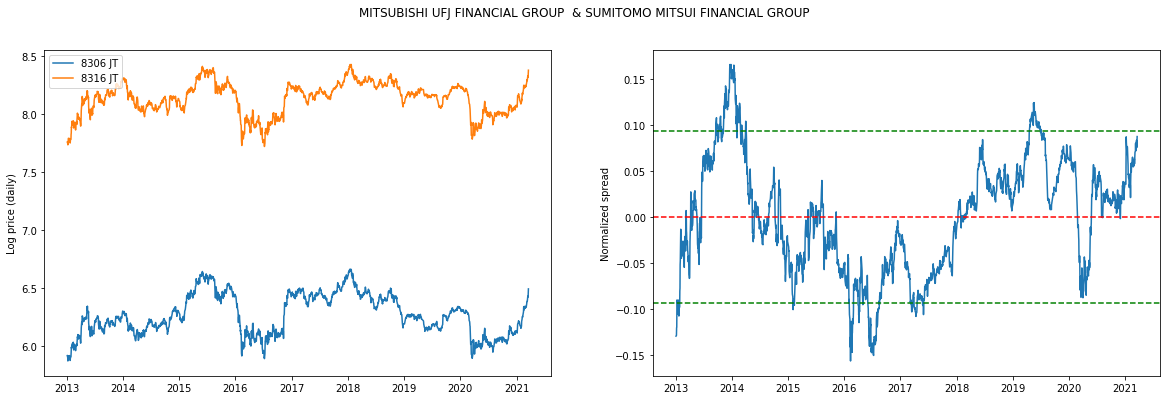

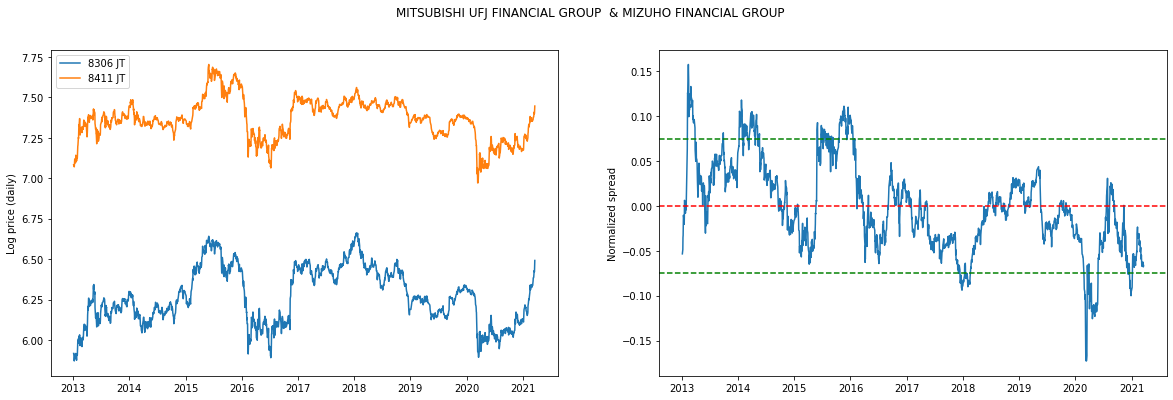

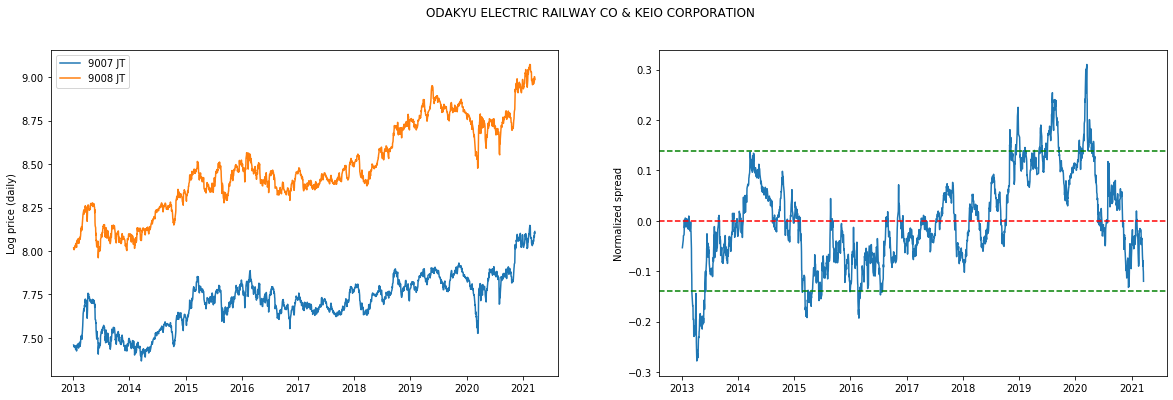

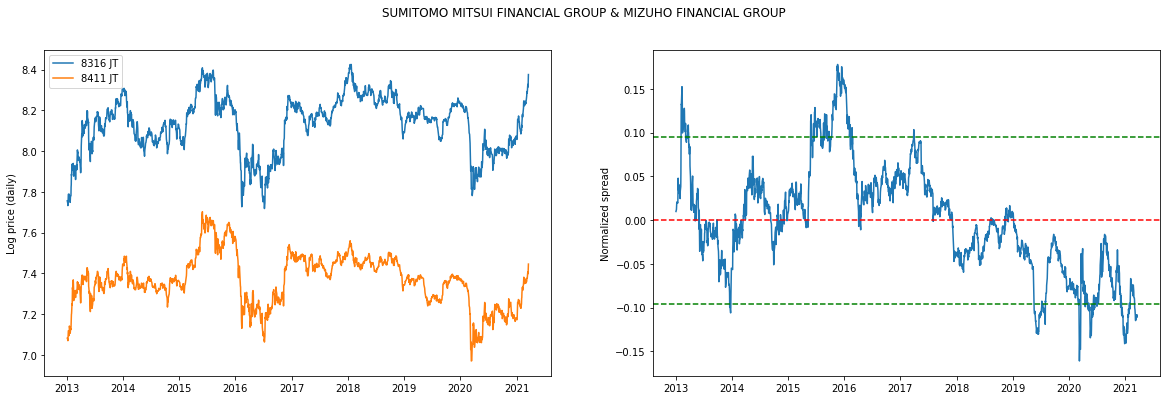

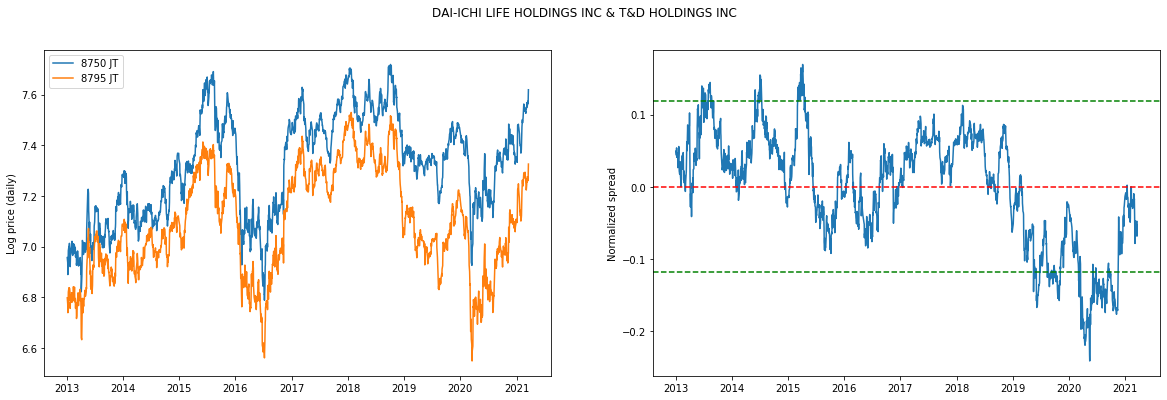

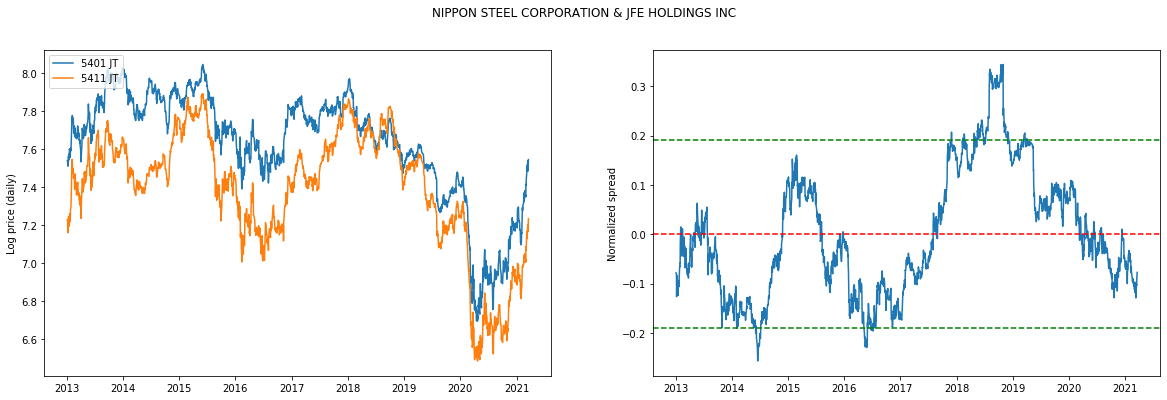

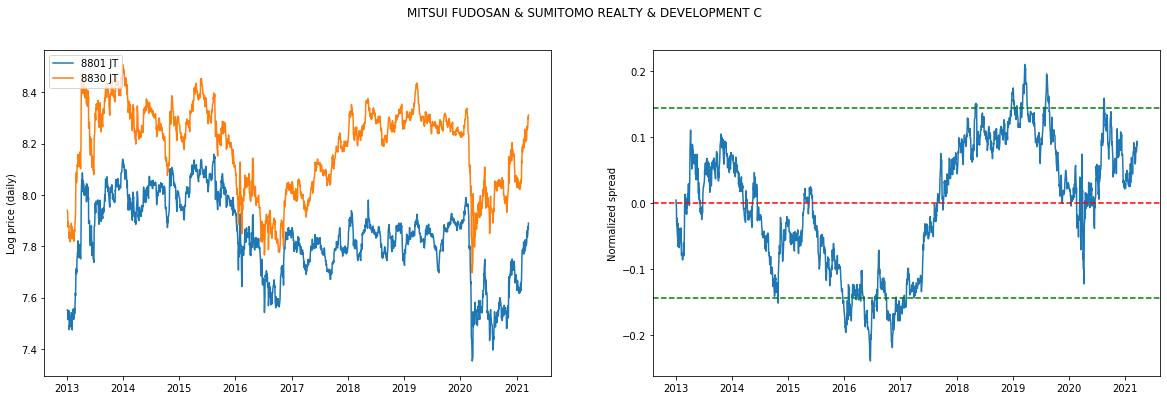

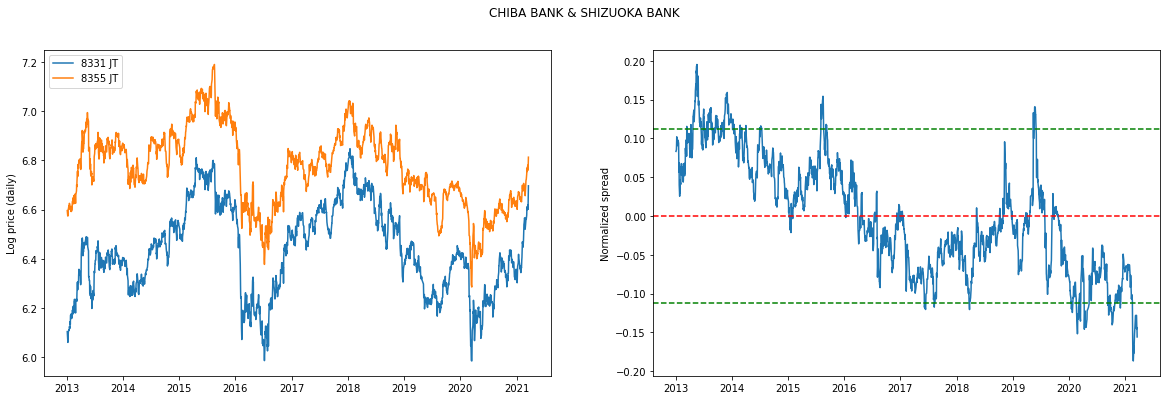

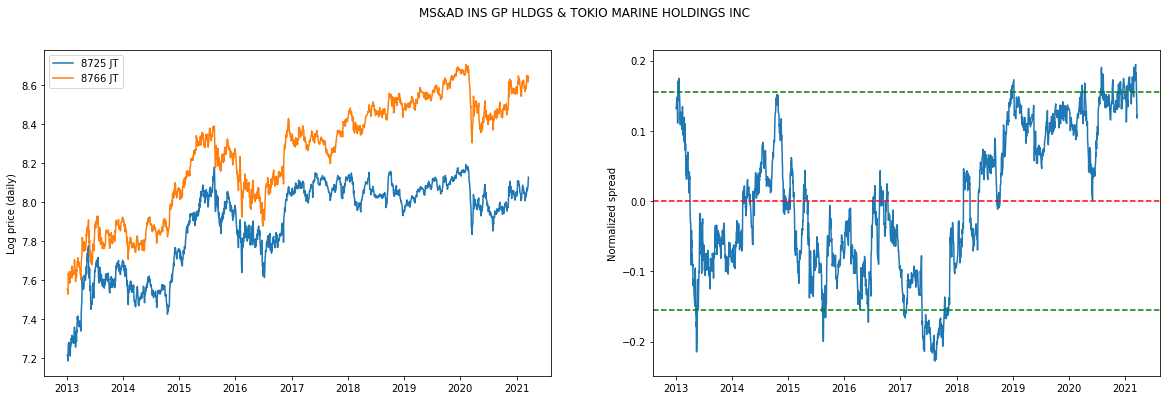

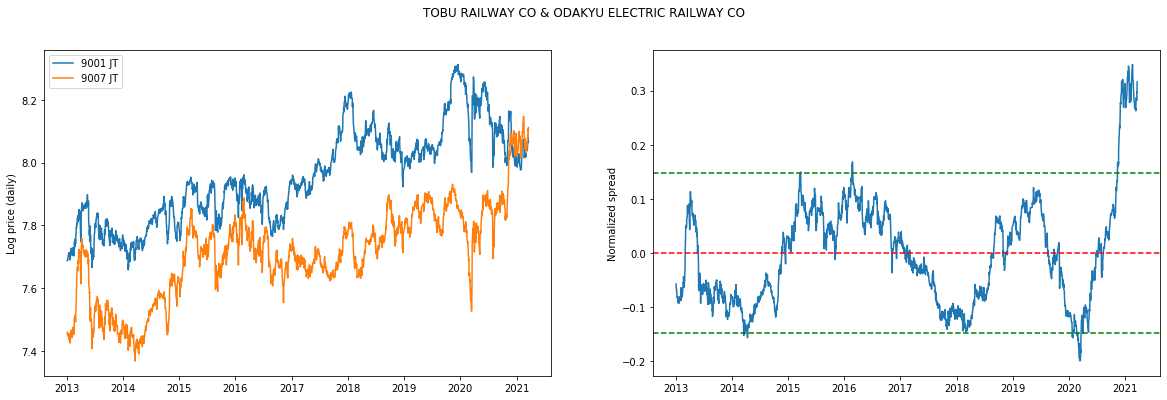

In [6]:
# Visualize the top 10 correlated stock pairs
for s1, s2 in pairs[:10]:
    name1 = yf.Ticker(s1.split(' ')[0] + '.T').info['shortName']
    name2 = yf.Ticker(s2.split(' ')[0] + '.T').info['shortName']
    
    x = logprice_df[s1]
    y = logprice_df[s2]
    spread, mu, sigma = get_norm_spread(x, y)
    
    fig, ax = plt.subplots(1, 2, figsize=(20,6))
    ax[0].plot(logprice_df[s1], label=s1)
    ax[0].plot(logprice_df[s2], label=s2)
    ax[0].set_ylabel('Log price (daily)')
    ax[0].legend(loc='upper left')
    ax[1].plot(spread)

    ax[1].axhline(mu, color='r', linestyle='dashed')
    ax[1].axhline(mu - 1.5*sigma, color='g', linestyle='dashed')
    ax[1].axhline(mu + 1.5*sigma, color='g', linestyle='dashed')
    ax[1].set_ylabel('Normalized spread')
    fig.suptitle(f'{name1} & {name2}')
    
    plt.show()

### Correlation Analysis
From the preliminary correlation analysis on log price change, we found 75 highly correlated (correlation of log return > 0.75) stock pairs (out of 248 stock). Amongst these, the top 10 most correlated pairs are in the same industry/sub-sector (e.g. financial service, real estate, railway, steel)

This offers good pairs trading opportunities when spread of the cointegrated pairs diverges and reverts. In specific, when their spread diverges (here taken as 1.5 SD of the historical price ratio), we buy the undervalued stock, and short sell the overvalued stock. By matching the long and short positions, we maintain a market neutral position.

Note: To achieve better pair trade selection, we can further utilize clustering technique, or even reinforcement learning models to find cointegrated pairs more efficiently.

From the above analysis, we conclude that statistical arbitrage opportunities exist (without considering transaction cost), however, due to the long mean-reverting period, there is considerably higher systematic risk over the long-holding period (especially under the current market with high inflation and FX risk). 

In this case, we would like to further explore other (swing/intraday) trading indicators.

## Trading indicators generation
We start by constructing 5 technical indicators based on the daily volume and price data. The 5 indicators are then used as input for a classification model to predict the next day's return.

In [7]:
def compute_vwap(df, look_back=5):
    '''
    Volume-weighted Average Price
    
    VWAP gives a better (and less noisy) view of the actual security value by taking into account of
    the trading volume, thus can be used to signal if security is overbought/oversold at fair price
    '''
    adj_close = df['last']
    vol = df['volume']
    vol_weighted_close = adj_close * vol
    vwap = vol_weighted_close.rolling(window=look_back).sum() / vol.rolling(window=look_back).sum()
    signal = adj_close - vwap
    return df.assign(vwap=vwap, vwap_signal=signal)
     
    
    
def compute_bb(df, look_back=5):
    '''
    Bollinger Band
    
    BB generates overbought/oversold signals when prices toucher the upper/lower band
    '''
    def compute_sma(adj_close, look_back):
        sma = adj_close.rolling(window=look_back, center=False).mean()
        ratio = adj_close/sma
        return sma, ratio
    
    adj_close = df['last']
    sma, _ = compute_sma(adj_close, look_back)
    rolling_std = adj_close.rolling(window=look_back, center=False).std()
    
    upper = sma + 2*rolling_std
    lower = sma - 2*rolling_std
    signal = (adj_close - sma) /(2*rolling_std)
    return df.assign(upper_bb=upper, lower_bb=lower, bb_signal=signal)



def compute_so(df, look_back=5, shift=5):
    '''
    Stochastic Oscillator
    
    SO measures the momentum of the security price to determine trends and indicate price reversal
    '''
    adj_close = df['last']
    recent_highest = adj_close.rolling(window=look_back, center=False).max().shift(shift)
    recent_lowest = adj_close.rolling(window=look_back, center=False).min().shift(shift)
    signal = (adj_close - recent_lowest) / (recent_highest - recent_lowest)
    return df.assign(so_signal=signal)



def compute_macd(df, 
                 fast_period=12, 
                 slow_period=26, 
                 norm_period=20, 
                 signal_period=9, 
                 smooth_period=5, 
                 smooth=False, 
                 shift=0):
    '''
    Moving Average Convergence Divergence
    
    MACD is trend-following, by measuring the relationship between 2 MAs of the security price
    '''
    adj_close = df['last']
    ema_fast = adj_close.ewm(span=fast_period).mean().shift(shift)
    ema_slow = adj_close.ewm(span=slow_period).mean().shift(shift)
    
    macd = ema_fast - ema_slow
    recent_max_macd = macd.rolling(window=norm_period, center=False).max()
    recent_min_macd = macd.rolling(window=norm_period, center=False).min()
    
    macd_normalized = (macd - recent_min_macd) / (recent_max_macd - recent_min_macd)
    macd_final = macd_normalized.ewm(span=smooth_period).mean() if smooth else macd_normalized
    signal = macd_final.ewm(span=signal_period).mean()
    
    return df.assign(macd_last=macd_final, macd_signal=signal)



def compute_momentum(df, look_back=15):
    '''
    Momentum
    '''
    adj_close = df['last']
    momentum = adj_close / adj_close.shift(look_back) - 1
    return df.assign(momentum=momentum)


In [8]:
df = df.sort_values(by='date')
df = df.groupby('ticker', group_keys=False).apply(compute_vwap)
df = df.groupby('ticker', group_keys=False).apply(compute_macd)
df = df.groupby('ticker', group_keys=False).apply(compute_bb)
df = df.groupby('ticker', group_keys=False).apply(compute_momentum)
df = df.groupby('ticker', group_keys=False).apply(compute_so)

In [9]:
# extract technical indicators for each ticker
df_merged = pd.pivot_table(df, index=['date'], 
                           values=[c for c in df.columns if c not in {'ticker', 'date'}], 
                           columns=['ticker'])

# add datetime features
df_merged['DT_quarter']        = df_merged.index.quarter
df_merged['DT_month']          = df_merged.index.month
df_merged['DT_weekofyear']     = df_merged.index.weekofyear
df_merged['DT_is_month_start'] = df_merged.index.is_month_start.astype(int)
df_merged['DT_is_month_end']   = df_merged.index.is_month_end.astype(int)
df_merged['DT_day']            = df_merged.index.day
df_merged['DT_dayofyear']      = df_merged.index.dayofyear
df_merged['DT_weekday']        = df_merged.index.weekday

## Model Training

Here, we employed CatBoost, a high performance Gradient Boosting Desicion Tree. With its symmetric/balanced tree structure, CatBoost outperformed the traditional XGBoost by approximately 3.5 times. Besides, CatBoost supports GPU environment by default, for working with large datasets like financial data.

We partitioned the data by 75%, 15% and 15% for training, validation and testing. In specific, trading data between 2013-01-04 and 2019-12-25 is used for model training and tuning, while trading data after 2019-12-25 is separated as holdout samples. 

Classifictaion metrics - BalancedErrorRate (average of the errors on positive and negative classes) is used to evaluate the model's performance:

$$
    {1 \over 2} ({FP \over {TN + FP}} + {FN \over {FN + TP}})
$$

A random guess has balanced error rate of 0.5. In this case, we are looking to minimize the balanced error rate of our model.

In [10]:
# Prepare model training and testing data
FR_THRESHOLD = 0.02
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15

def compute_return(x):
    '''
    Helper function to label training data
    '''
    return 1 if x['next_day_return'] > FR_THRESHOLD else \
         (-1 if x['next_day_return'] < -FR_THRESHOLD else np.nan)


dates = df_merged.index
start_date, end_date = dates.min(), dates.max()
last_train_date = dates.min() + (dates.max() - dates.min()) * (TRAIN_SIZE + VAL_SIZE)
print(start_date.date(), end_date.date(), last_train_date.date())


train_val_df, test_df = pd.DataFrame(), pd.DataFrame()

raw_features = ['last', 'volume']
dt_features = [i for (i, j) in df_merged.columns if i.startswith('DT')]
indicator_features = list(set([i for (i, j) in df_merged.columns if (not i.startswith('DT')) and 
                                                                    (not i in {'last', 'volume'})]))
all_tickers = sorted(list(set([j for (i, j) in df_merged.columns if (not i.startswith('DT')) and 
                                                                    (not i in {'last', 'volume'})])))

for ticker in all_tickers:
    indic_data = df_merged[[(f, ticker) for f in indicator_features+raw_features]]
    dt_data = df_merged[dt_features]
    ticker_data = pd.concat([indic_data, dt_data], axis=1)
    ticker_data.columns = ticker_data.columns.get_level_values(0)
    ticker_data['next_day_return'] = ticker_data['last'].shift(-1) / ticker_data['last'] - 1
    ticker_data['label'] = ticker_data.apply(lambda x: compute_return(x), axis=1)
    ticker_data['ticker'] = ticker
    ticker_data.dropna(inplace=True)
    train_val_df = train_val_df.append(ticker_data[:last_train_date])
    test_df = test_df.append(ticker_data[last_train_date:])

print('\nTraining and validation dataset:', train_val_df.shape)
print('Testing dataset:', test_df.shape)

2013-01-04 2021-03-19 2019-12-25

Training and validation dataset: (88814, 22)
Testing dataset: (21249, 22)


In [12]:
N = train_val_df.shape[0]
feature_names = [c for c in train_df.columns if c not in {'label', 'next_day_return', 'ticker'}]
train_df, val_df = train_val_df.iloc[:int(TRAIN_SIZE*N)], train_val_df.iloc[int(TRAIN_SIZE*N):]
splits = {'train': train_df, 'val': val_df}


pools = {
    s: Pool(
        data=splits[s][feature_names],
        label=splits[s]['label'],
        cat_features=dt_features,
    ) for s in ['train', 'val']
}

params = {
    "task_type": "CPU",
    "devices": '0',
    "max_ctr_complexity": 1,
    "boosting_type": "Plain",
    "use_best_model": True,
    "iterations": 1000,
    "eval_metric": "BalancedErrorRate",
    "early_stopping_rounds": 200,
    "objective": "Logloss",
    "depth": 6,
}

model = CatBoostClassifier(**params)
model.fit(pools['train'], eval_set=pools['val'], use_best_model=True, verbose=1)

Learning rate set to 0.087886
0:	learn: 0.3028359	test: 0.2837515	best: 0.2837515 (0)	total: 104ms	remaining: 1m 43s
1:	learn: 0.3029289	test: 0.2863177	best: 0.2837515 (0)	total: 132ms	remaining: 1m 5s
2:	learn: 0.3052323	test: 0.2902098	best: 0.2837515 (0)	total: 159ms	remaining: 52.8s
3:	learn: 0.3029184	test: 0.2866483	best: 0.2837515 (0)	total: 185ms	remaining: 46s
4:	learn: 0.3027371	test: 0.2858619	best: 0.2837515 (0)	total: 228ms	remaining: 45.4s
5:	learn: 0.3029070	test: 0.2869424	best: 0.2837515 (0)	total: 258ms	remaining: 42.8s
6:	learn: 0.3029243	test: 0.2863042	best: 0.2837515 (0)	total: 285ms	remaining: 40.4s
7:	learn: 0.3002588	test: 0.2826797	best: 0.2826797 (7)	total: 317ms	remaining: 39.3s
8:	learn: 0.2992548	test: 0.2827907	best: 0.2826797 (7)	total: 346ms	remaining: 38.1s
9:	learn: 0.2984284	test: 0.2815343	best: 0.2815343 (9)	total: 377ms	remaining: 37.3s
10:	learn: 0.2983213	test: 0.2813413	best: 0.2813413 (10)	total: 406ms	remaining: 36.5s
11:	learn: 0.2979903	te

95:	learn: 0.2594166	test: 0.2425775	best: 0.2425775 (95)	total: 3.65s	remaining: 34.4s
96:	learn: 0.2593747	test: 0.2418463	best: 0.2418463 (96)	total: 3.74s	remaining: 34.8s
97:	learn: 0.2588128	test: 0.2417558	best: 0.2417558 (97)	total: 3.78s	remaining: 34.8s
98:	learn: 0.2586330	test: 0.2413400	best: 0.2413400 (98)	total: 3.82s	remaining: 34.8s
99:	learn: 0.2585338	test: 0.2413591	best: 0.2413400 (98)	total: 3.87s	remaining: 34.8s
100:	learn: 0.2579508	test: 0.2401612	best: 0.2401612 (100)	total: 3.92s	remaining: 34.9s
101:	learn: 0.2575638	test: 0.2402493	best: 0.2401612 (100)	total: 3.96s	remaining: 34.9s
102:	learn: 0.2574961	test: 0.2403679	best: 0.2401612 (100)	total: 4s	remaining: 34.9s
103:	learn: 0.2565592	test: 0.2397264	best: 0.2397264 (103)	total: 4.04s	remaining: 34.8s
104:	learn: 0.2564366	test: 0.2396549	best: 0.2396549 (104)	total: 4.11s	remaining: 35s
105:	learn: 0.2559263	test: 0.2395773	best: 0.2395773 (105)	total: 4.21s	remaining: 35.5s
106:	learn: 0.2556997	tes

189:	learn: 0.2291221	test: 0.2191216	best: 0.2188167 (188)	total: 8.52s	remaining: 36.3s
190:	learn: 0.2289592	test: 0.2191892	best: 0.2188167 (188)	total: 8.56s	remaining: 36.3s
191:	learn: 0.2287383	test: 0.2192173	best: 0.2188167 (188)	total: 8.6s	remaining: 36.2s
192:	learn: 0.2285843	test: 0.2192492	best: 0.2188167 (188)	total: 8.65s	remaining: 36.2s
193:	learn: 0.2284852	test: 0.2190311	best: 0.2188167 (188)	total: 8.69s	remaining: 36.1s
194:	learn: 0.2286190	test: 0.2187772	best: 0.2187772 (194)	total: 8.73s	remaining: 36s
195:	learn: 0.2281594	test: 0.2187096	best: 0.2187096 (195)	total: 8.77s	remaining: 36s
196:	learn: 0.2281441	test: 0.2187453	best: 0.2187096 (195)	total: 8.81s	remaining: 35.9s
197:	learn: 0.2279055	test: 0.2183219	best: 0.2183219 (197)	total: 8.86s	remaining: 35.9s
198:	learn: 0.2279611	test: 0.2182861	best: 0.2182861 (198)	total: 8.91s	remaining: 35.9s
199:	learn: 0.2280441	test: 0.2185553	best: 0.2182861 (198)	total: 8.96s	remaining: 35.8s
200:	learn: 0.2

283:	learn: 0.2159010	test: 0.2113423	best: 0.2113423 (283)	total: 13s	remaining: 32.8s
284:	learn: 0.2156446	test: 0.2108193	best: 0.2108193 (284)	total: 13.1s	remaining: 32.8s
285:	learn: 0.2155801	test: 0.2107250	best: 0.2107250 (285)	total: 13.1s	remaining: 32.8s
286:	learn: 0.2154349	test: 0.2106893	best: 0.2106893 (286)	total: 13.2s	remaining: 32.7s
287:	learn: 0.2152245	test: 0.2109470	best: 0.2106893 (286)	total: 13.2s	remaining: 32.7s
288:	learn: 0.2149237	test: 0.2108360	best: 0.2106893 (286)	total: 13.3s	remaining: 32.7s
289:	learn: 0.2146899	test: 0.2109508	best: 0.2106893 (286)	total: 13.3s	remaining: 32.6s
290:	learn: 0.2146093	test: 0.2107646	best: 0.2106893 (286)	total: 13.4s	remaining: 32.5s
291:	learn: 0.2144908	test: 0.2105502	best: 0.2105502 (291)	total: 13.4s	remaining: 32.5s
292:	learn: 0.2142973	test: 0.2109813	best: 0.2105502 (291)	total: 13.4s	remaining: 32.4s
293:	learn: 0.2142586	test: 0.2109341	best: 0.2105502 (291)	total: 13.5s	remaining: 32.4s
294:	learn: 

378:	learn: 0.2055967	test: 0.2056040	best: 0.2056040 (378)	total: 17.4s	remaining: 28.5s
379:	learn: 0.2054540	test: 0.2055606	best: 0.2055606 (379)	total: 17.4s	remaining: 28.4s
380:	learn: 0.2050783	test: 0.2055454	best: 0.2055454 (380)	total: 17.4s	remaining: 28.3s
381:	learn: 0.2050259	test: 0.2052239	best: 0.2052239 (381)	total: 17.5s	remaining: 28.3s
382:	learn: 0.2047969	test: 0.2052915	best: 0.2052239 (381)	total: 17.5s	remaining: 28.3s
383:	learn: 0.2046542	test: 0.2049981	best: 0.2049981 (383)	total: 17.6s	remaining: 28.2s
384:	learn: 0.2046510	test: 0.2052048	best: 0.2049981 (383)	total: 17.6s	remaining: 28.1s
385:	learn: 0.2044865	test: 0.2050148	best: 0.2049981 (383)	total: 17.7s	remaining: 28.1s
386:	learn: 0.2041011	test: 0.2049152	best: 0.2049152 (386)	total: 17.7s	remaining: 28s
387:	learn: 0.2042237	test: 0.2046142	best: 0.2046142 (387)	total: 17.7s	remaining: 28s
388:	learn: 0.2042108	test: 0.2044713	best: 0.2044713 (388)	total: 17.8s	remaining: 27.9s
389:	learn: 0.

473:	learn: 0.1967964	test: 0.2020351	best: 0.2020351 (473)	total: 21.6s	remaining: 23.9s
474:	learn: 0.1968069	test: 0.2021370	best: 0.2020351 (473)	total: 21.6s	remaining: 23.9s
475:	learn: 0.1967642	test: 0.2022237	best: 0.2020351 (473)	total: 21.7s	remaining: 23.9s
476:	learn: 0.1966876	test: 0.2018155	best: 0.2018155 (476)	total: 21.7s	remaining: 23.8s
477:	learn: 0.1965199	test: 0.2018079	best: 0.2018079 (477)	total: 21.9s	remaining: 23.9s
478:	learn: 0.1963845	test: 0.2015350	best: 0.2015350 (478)	total: 21.9s	remaining: 23.9s
479:	learn: 0.1961192	test: 0.2012302	best: 0.2012302 (479)	total: 22s	remaining: 23.8s
480:	learn: 0.1961377	test: 0.2010797	best: 0.2010797 (480)	total: 22s	remaining: 23.8s
481:	learn: 0.1960014	test: 0.2010211	best: 0.2010211 (481)	total: 22.1s	remaining: 23.7s
482:	learn: 0.1959708	test: 0.2009854	best: 0.2009854 (482)	total: 22.1s	remaining: 23.7s
483:	learn: 0.1959313	test: 0.2009892	best: 0.2009854 (482)	total: 22.2s	remaining: 23.6s
484:	learn: 0.

568:	learn: 0.1881396	test: 0.1978938	best: 0.1978619 (566)	total: 28.5s	remaining: 21.6s
569:	learn: 0.1881396	test: 0.1979295	best: 0.1978619 (566)	total: 28.5s	remaining: 21.5s
570:	learn: 0.1880840	test: 0.1978900	best: 0.1978619 (566)	total: 28.6s	remaining: 21.5s
571:	learn: 0.1879550	test: 0.1977037	best: 0.1977037 (571)	total: 28.6s	remaining: 21.4s
572:	learn: 0.1876599	test: 0.1976323	best: 0.1976323 (572)	total: 28.7s	remaining: 21.4s
573:	learn: 0.1875648	test: 0.1975175	best: 0.1975175 (573)	total: 28.8s	remaining: 21.3s
574:	learn: 0.1875245	test: 0.1975570	best: 0.1975175 (573)	total: 28.8s	remaining: 21.3s
575:	learn: 0.1874003	test: 0.1981119	best: 0.1975175 (573)	total: 28.9s	remaining: 21.2s
576:	learn: 0.1873866	test: 0.1980086	best: 0.1975175 (573)	total: 28.9s	remaining: 21.2s
577:	learn: 0.1875728	test: 0.1977114	best: 0.1975175 (573)	total: 29s	remaining: 21.1s
578:	learn: 0.1876099	test: 0.1977828	best: 0.1975175 (573)	total: 29s	remaining: 21.1s
579:	learn: 0.

662:	learn: 0.1819846	test: 0.1968979	best: 0.1967154 (652)	total: 33.6s	remaining: 17.1s
663:	learn: 0.1819080	test: 0.1969017	best: 0.1967154 (652)	total: 33.8s	remaining: 17.1s
664:	learn: 0.1819217	test: 0.1971274	best: 0.1967154 (652)	total: 33.9s	remaining: 17.1s
665:	learn: 0.1818032	test: 0.1970165	best: 0.1967154 (652)	total: 34.1s	remaining: 17.1s
666:	learn: 0.1818322	test: 0.1968826	best: 0.1967154 (652)	total: 34.3s	remaining: 17.1s
667:	learn: 0.1819274	test: 0.1972422	best: 0.1967154 (652)	total: 34.4s	remaining: 17.1s
668:	learn: 0.1817540	test: 0.1972384	best: 0.1967154 (652)	total: 34.5s	remaining: 17.1s
669:	learn: 0.1817032	test: 0.1970484	best: 0.1967154 (652)	total: 34.5s	remaining: 17s
670:	learn: 0.1816347	test: 0.1971555	best: 0.1967154 (652)	total: 34.6s	remaining: 17s
671:	learn: 0.1813549	test: 0.1975432	best: 0.1967154 (652)	total: 34.6s	remaining: 16.9s
672:	learn: 0.1811646	test: 0.1973927	best: 0.1967154 (652)	total: 34.7s	remaining: 16.9s
673:	learn: 0.

758:	learn: 0.1755347	test: 0.1943026	best: 0.1941802 (745)	total: 39.3s	remaining: 12.5s
759:	learn: 0.1753799	test: 0.1943078	best: 0.1941802 (745)	total: 39.4s	remaining: 12.4s
760:	learn: 0.1753984	test: 0.1943588	best: 0.1941802 (745)	total: 39.4s	remaining: 12.4s
761:	learn: 0.1752735	test: 0.1940654	best: 0.1940654 (761)	total: 39.4s	remaining: 12.3s
762:	learn: 0.1753396	test: 0.1939977	best: 0.1939977 (762)	total: 39.5s	remaining: 12.3s
763:	learn: 0.1752671	test: 0.1939977	best: 0.1939977 (762)	total: 39.6s	remaining: 12.2s
764:	learn: 0.1750994	test: 0.1939339	best: 0.1939339 (764)	total: 39.6s	remaining: 12.2s
765:	learn: 0.1751485	test: 0.1938396	best: 0.1938396 (765)	total: 39.7s	remaining: 12.1s
766:	learn: 0.1751026	test: 0.1937644	best: 0.1937644 (766)	total: 39.7s	remaining: 12.1s
767:	learn: 0.1751010	test: 0.1936929	best: 0.1936929 (767)	total: 39.8s	remaining: 12s
768:	learn: 0.1751623	test: 0.1938039	best: 0.1936929 (767)	total: 39.8s	remaining: 12s
769:	learn: 0.

853:	learn: 0.1699104	test: 0.1924598	best: 0.1919049 (848)	total: 45.1s	remaining: 7.72s
854:	learn: 0.1698701	test: 0.1924560	best: 0.1919049 (848)	total: 45.2s	remaining: 7.66s
855:	learn: 0.1698040	test: 0.1925312	best: 0.1919049 (848)	total: 45.2s	remaining: 7.61s
856:	learn: 0.1697749	test: 0.1925746	best: 0.1919049 (848)	total: 45.3s	remaining: 7.55s
857:	learn: 0.1698378	test: 0.1925746	best: 0.1919049 (848)	total: 45.3s	remaining: 7.5s
858:	learn: 0.1697532	test: 0.1923564	best: 0.1919049 (848)	total: 45.4s	remaining: 7.45s
859:	learn: 0.1697072	test: 0.1924560	best: 0.1919049 (848)	total: 45.4s	remaining: 7.39s
860:	learn: 0.1696645	test: 0.1920835	best: 0.1919049 (848)	total: 45.5s	remaining: 7.34s
861:	learn: 0.1696677	test: 0.1920045	best: 0.1919049 (848)	total: 45.5s	remaining: 7.28s
862:	learn: 0.1694379	test: 0.1922378	best: 0.1919049 (848)	total: 45.5s	remaining: 7.23s
863:	learn: 0.1693951	test: 0.1921588	best: 0.1919049 (848)	total: 45.6s	remaining: 7.18s
864:	learn:

945:	learn: 0.1651245	test: 0.1907494	best: 0.1905913 (940)	total: 51.5s	remaining: 2.94s
946:	learn: 0.1650415	test: 0.1906704	best: 0.1905913 (940)	total: 51.6s	remaining: 2.88s
947:	learn: 0.1651044	test: 0.1906985	best: 0.1905913 (940)	total: 51.6s	remaining: 2.83s
948:	learn: 0.1651334	test: 0.1907061	best: 0.1905913 (940)	total: 51.6s	remaining: 2.77s
949:	learn: 0.1651350	test: 0.1905913	best: 0.1905913 (940)	total: 51.7s	remaining: 2.72s
950:	learn: 0.1649907	test: 0.1906194	best: 0.1905913 (940)	total: 51.8s	remaining: 2.67s
951:	learn: 0.1649125	test: 0.1904256	best: 0.1904256 (951)	total: 51.8s	remaining: 2.61s
952:	learn: 0.1650648	test: 0.1903617	best: 0.1903617 (952)	total: 51.8s	remaining: 2.56s
953:	learn: 0.1650229	test: 0.1904013	best: 0.1903617 (952)	total: 51.9s	remaining: 2.5s
954:	learn: 0.1650245	test: 0.1904332	best: 0.1903617 (952)	total: 51.9s	remaining: 2.45s
955:	learn: 0.1649342	test: 0.1902470	best: 0.1902470 (955)	total: 52s	remaining: 2.39s
956:	learn: 0

## Backtesting:  Calculate PnL 

In [13]:
def calc_pnl(preds, df):
    '''
    Trade based on predicted signals and compute profit/loss for the strategy
    '''
    THRESHOLD = 0.75
    all_tickers = df['ticker'].unique()
    positions = {ticker:0 for ticker in all_tickers}
    pnl = 0
    
    for i, probs in enumerate(preds):  
        ticker = df.iloc[i]['ticker']
        neg_class_prob, pos_class_prob = probs

        # enter a long position
        if pos_class_prob > THRESHOLD:
            positions[ticker] += 1
            pnl -= df.iloc[i]['last']

        # enter a short position
        elif neg_class_prob > THRESHOLD:
            positions[ticker] -= 1
            pnl += df.iloc[i]['last']  

        # close out long/short position
        elif positions[ticker] != 0:
            pnl += df.iloc[i]['last'] * positions[ticker]
            positions[ticker] = 0
    return pnl, positions

In [14]:
preds = model.predict_proba(test_df[feature_names])
pnl, order_book = calc_pnl(preds, test_df)
print(f'Backtesting: PnL of the trading strategy: {pnl}' )

Backtesting: PnL of the trading strategy: -134669.2581999997


In [15]:
y_pred = np.rint(preds)[:,0]
print(y_pred.shape, y_pred)

y_true = test_df['label']
y_true[y_true < 0] = 0
y_true = np.array(y_true)
print(y_true.shape, y_true)

print('\nTesting: Balanced error rate:', balanced_accuracy_score(y_true, y_pred))

(21249,) [1. 0. 0. ... 1. 1. 0.]
(21249,) [0. 0. 0. ... 1. 0. 0.]

Testing: Balanced error rate: 0.47061269947507156


## Future Work

The model overfits by demonstrating a lower error score (0.189) in training stage and a higher error score (0.470) in testing. To handle overfitting and tune the hyperparameter, we can leverage Optuna, a hyperparameter optimization framework to get the best model. 

Unfortunately, as my limited computing resources do not allow me to run with Optuna, the model hyperparameter was only tuned manually. However, as we further tune and optimize the CatBoost model hyperparameter, we should expect to avoid model overfitting and get a more optimal trading strategy.

Also note that in this trading strategy, we clear all our position at the start of the day if there is no trading signals on the same day to minimize overnight risk. As the future work, as we obtain more data on the price movement (e.g. company's financial metrics), we will able to construct more systematic trading indicators and indicate a more optimal exit timing.

In [ ]:
class CatBoostOptuna:
    def __init__(self, df, train_size, feature_names, base_params):
        self.best_model = None
        self._model = None
        self.df = df
        self.train_size = train_size
        self.feature_names = feature_names
        self.base_params = {
            'task_type': 'CPU',
            'devices': '0',
            'max_ctr_complexity': 1,
            'boosting_type': 'Plain',
            'use_best_model': True,
            'iterations': 1000,
            'eval_metric': 'BalancedErrorRate',
            'early_stopping_rounds': 200,
            'objective': 'Logloss',
            'depth': 6
        }

    def callback(self, study, trial):
        if study.best_trial == trial:
            self.best_model = self._model
        
        
    def __call__(self, trial):
        N = self.df.shape[0]
        train_df, val_df = self.df.iloc[:int(self.train_size*N)], self.df.iloc[int(self.train_size*N):]
        splits = {'train': train_df, 'val': val_df}
        pools = {
            s: Pool(
                data = splits[s][self.feature_names],
                label = splits[s]['label'],
            ) for s in ['train', 'val']
        }
        param = self.base_params
        param = {k: v for k, v in self.base_params.items()}
        param.update({
            'depth': trial.suggest_int('depth', 3, 11),
            'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
            'score_function': trial.suggest_categorical('score_function', ['Cosine', 'L2']),
            'l2_leaf_reg': trial.suggest_float('random_strength', 1.0, 70.0),
        })
        if param['bootstrap_type'] == 'Bayesian':
            param['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 300)
        elif param['bootstrap_type'] == 'Bernoulli':
            param['subsample'] = trial.suggest_float('subsample', 0.1, 1)

        self._model = CatBoostClassifier(**param)
        self._model.fit(pools['train'], eval_set=pools['val'], use_best_model=True, verbose=1)
        val_preds = self._model.predict(pools['val'])
        val_preds_class = np.rint(val_preds)[:,0]

        return balanced_accuracy_score(pools['val'].get_label(), val_preds_class)
        

In [ ]:
catboost = CatBoostOptuna(train_val_df, TRAIN_SIZE, feature_names, params)
study = optuna.create_study(direction='maximize')
study.optimize(catboost, n_trials=10, callbacks=[catboost.callback])
best_model = catboost.best_model
preds = best_model.predict_proba(test_df[feature_names])
pnl, order_book = calc_pnl(preds, test_df)
print(f'Backtesting: PnL of the trading strategy: {pnl}' )